In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# source the nxcals python libs
from nxcals.api.extraction.data.builders import *
from datetime import datetime
from datetime import timedelta
import pickle
from matplotlib import gridspec
import seaborn as sns

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 18
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [4]:
# Gain
with open('../quad-scan-east/rfko_gain_dataframe.pickle', 'rb') as f:
    gain_df = pickle.load(f)
gain_df['timestamp'] -= timedelta(hours=1)

# Time in UTC
start = gain_df['timestamp'].min()
stop = gain_df['timestamp'].max()
selector = ['CPS.USER.MD5', 'CPS.USER.EAST3', 'CPS.USER.EAST4']

spills = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(stop).entity().parameter("T08.XSEC070-I/SpillData").build()

spills = spills.filter(spills.selector.isin(selector)).toPandas()

# Convert the 'acqStamp' column to datetime and create a new column
spills['timestamp'] = pd.to_datetime(spills['acqStamp'], unit='ns')
spills['intensity'] = spills['semSpillData'].apply(lambda x: abs(sum(x['elements'])))

def calculate_flux(row):
    if row['selector'] == 'CPS.USER.EAST3':
        return abs(row["semSpillData"]["elements"].sum())*78.5/400 + 398.6
    elif row['selector'] == 'CPS.USER.MD5':
        return abs(row["semSpillData"]["elements"].sum())*34.4/400 + 58.4
    elif row['selector'] == 'CPS.USER.EAST4':
        return abs(row["semSpillData"]["elements"].sum())*125/400 + 0.0
    else:
        return np.nan

spills['flux'] = spills.apply(calculate_flux, axis=1)

spills_sorted = spills.sort_values(by='timestamp')

# Merge with the gain dataframe
merge_df = pd.merge_asof(spills_sorted, gain_df, on='timestamp', direction='nearest')
df = merge_df[['timestamp','selector', 'flux', 'gain','intensity']]

# calculate the difference in time (in seconds) and 'gain' between each row
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
df['gain_diff'] = df['gain'].diff()

23/11/10 14:19:02 WARN URLConfigurationSource: No URLs will be polled as dynamic configuration sources.
23/11/10 14:19:10 WARN CheckAllocator: More than one DefaultAllocationManager on classpath. Choosing first found


/tmp/ipykernel_592/2750976256.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
/tmp/ipykernel_592/2750976256.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gain_diff'] = df['gain'].diff()


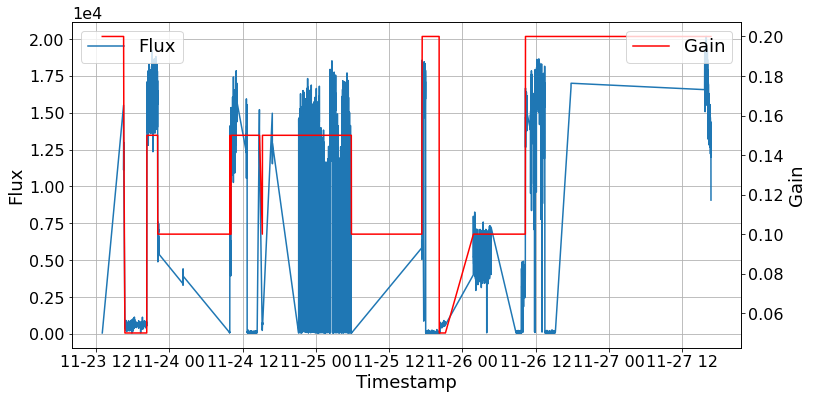

In [50]:
import matplotlib.pyplot as plt

# Define the gain values
gain_values = [0.05, 0.1, 0.15, 0.2]

# Filter the data for selector EAST3 and the specified gain values
filtered_df = df[(df['selector'] == 'CPS.USER.MD5') & (df['gain'].isin(gain_values))]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the flux vs. timestamp
ax.plot(filtered_df['timestamp'], filtered_df['flux'], label='Flux')

# Create a twin axis for the gain values
ax2 = ax.twinx()
ax2.plot(filtered_df['timestamp'], filtered_df['gain'], c="r", label='Gain')

# Set labels and legends
ax.set_xlabel('Timestamp')
ax.set_ylabel('Flux')
ax2.set_ylabel('Gain')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the grid
ax.grid(True)

# Show the plot
plt.show()


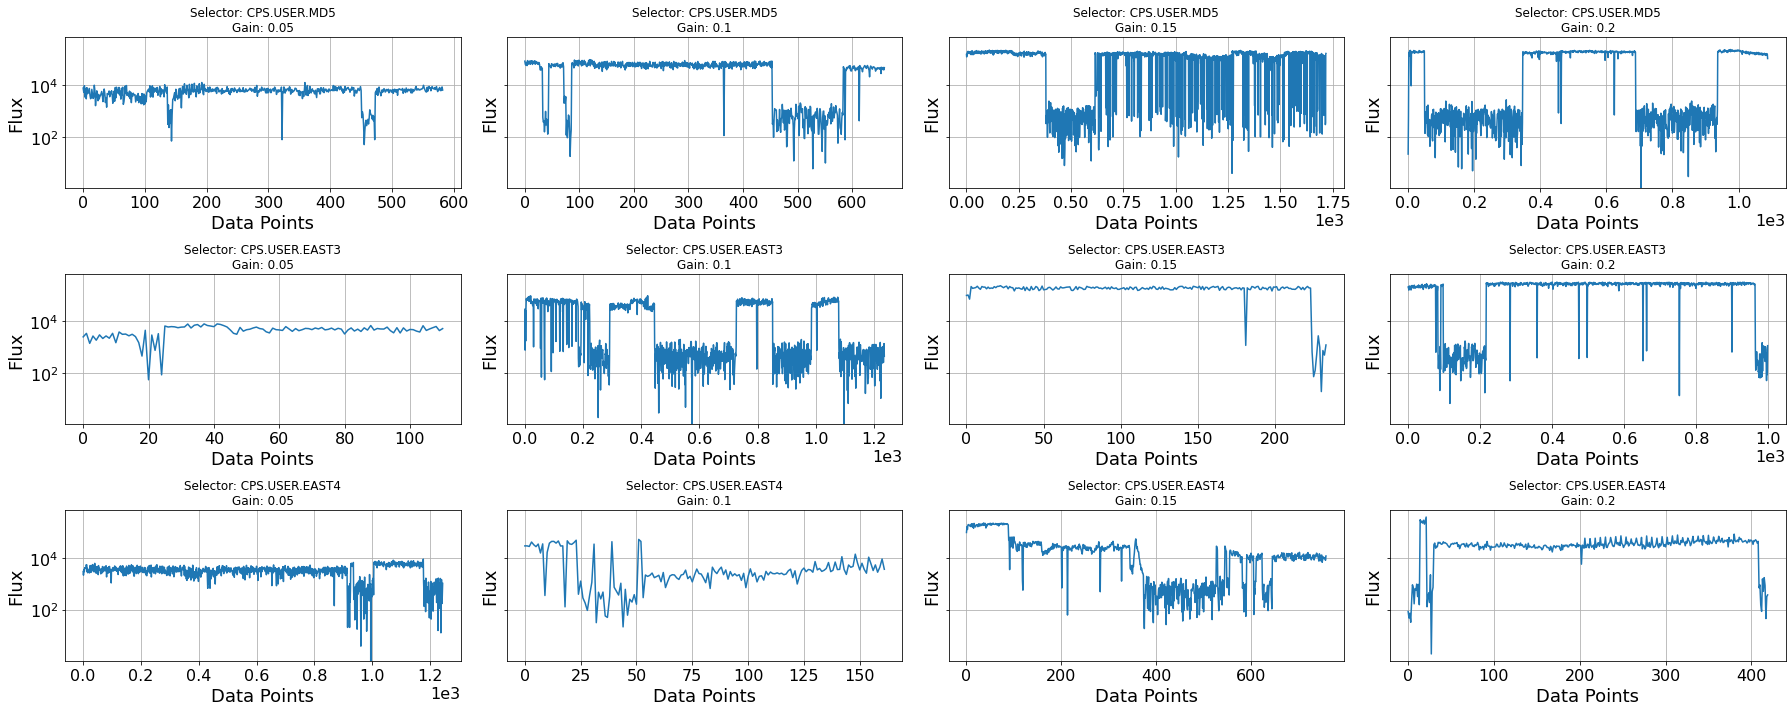

In [68]:
# Define the selectors and gain values
selectors = ['CPS.USER.MD5', 'CPS.USER.EAST3', 'CPS.USER.EAST4']
gain_values = [0.05, 0.1, 0.15, 0.2]

# Create a subplot for each combination of selector and gain
num_rows = len(selectors)
num_cols = len(gain_values)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 10), sharey=True)

# Iterate over each combination and plot the flux vs. data points
for i, selector in enumerate(selectors):
    for j, gain in enumerate(gain_values):
        # Filter the data for the current selector and gain
        filtered_df = df[(df['selector'] == selector) & (df['gain'] == gain)]
        
        # Calculate even x-spacing between the data points
        x_values = np.arange(len(filtered_df))
        
        # Plot the flux vs. x-values in the corresponding subplot
        axes[i, j].plot(x_values, filtered_df['intensity'])
        axes[i, j].set_title(f'Selector: {selector}\nGain: {gain}')
        axes[i, j].set_xlabel('Data Points')
        axes[i, j].set_ylabel('Flux')
        axes[i, j].grid(True)
        axes[i, j].set_yscale("log")
#         axes[i, j].set_ylim(2e1,2e5)

        
# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

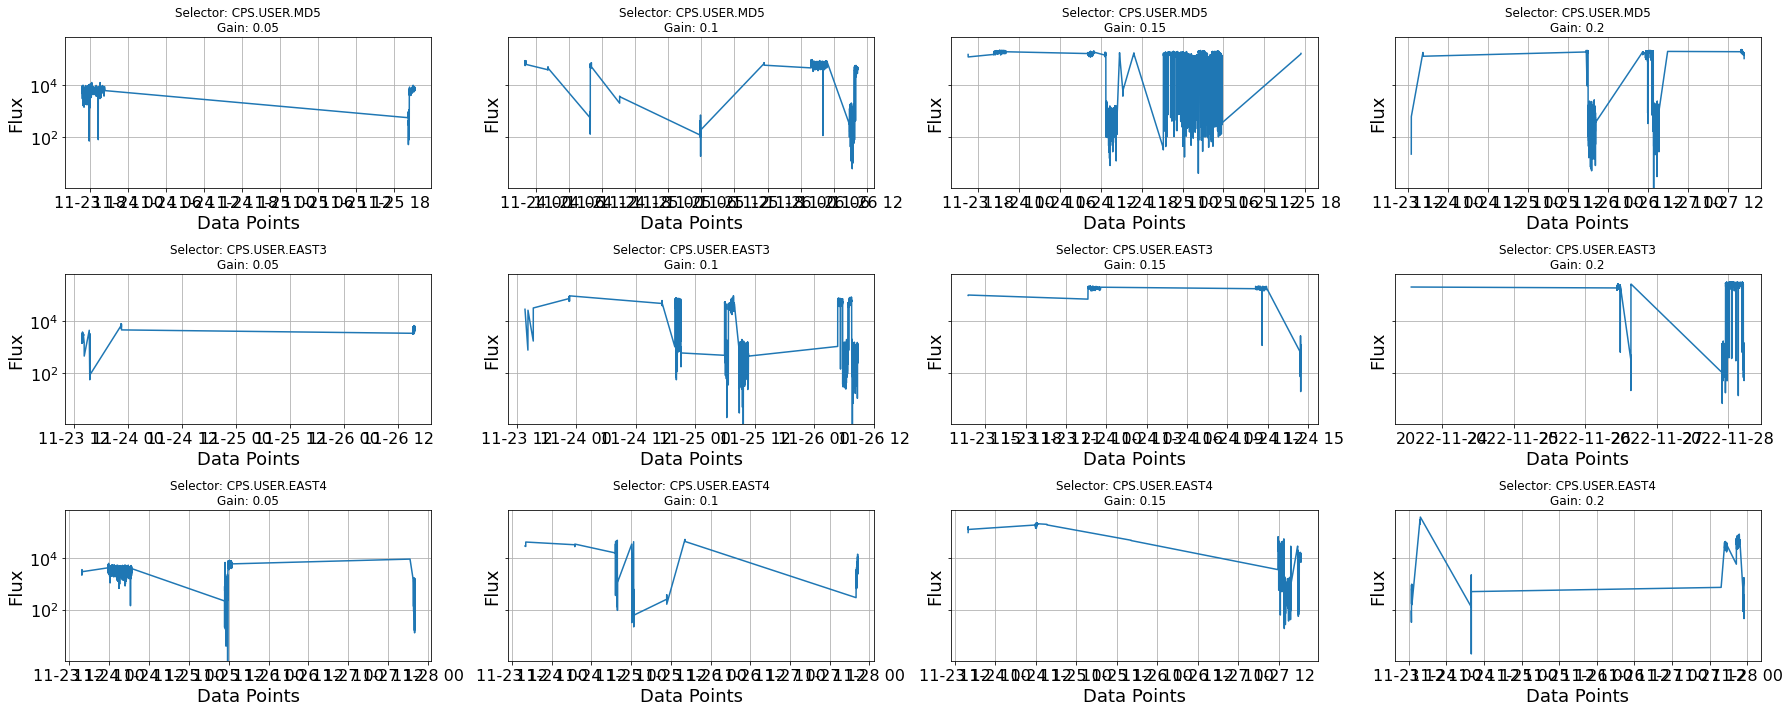

In [69]:
# Define the selectors and gain values
selectors = ['CPS.USER.MD5', 'CPS.USER.EAST3', 'CPS.USER.EAST4']
gain_values = [0.05, 0.1, 0.15, 0.2]

# Create a subplot for each combination of selector and gain
num_rows = len(selectors)
num_cols = len(gain_values)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 10), sharey=True)

# Iterate over each combination and plot the flux vs. data points
for i, selector in enumerate(selectors):
    for j, gain in enumerate(gain_values):
        # Filter the data for the current selector and gain
        filtered_df = df[(df['selector'] == selector) & (df['gain'] == gain)]
        
        # Calculate even x-spacing between the data points
        x_values = np.arange(len(filtered_df))
        
        # Plot the flux vs. x-values in the corresponding subplot
        axes[i, j].plot(filtered_df['timestamp'], filtered_df['intensity'])
        axes[i, j].set_title(f'Selector: {selector}\nGain: {gain}')
        axes[i, j].set_xlabel('Data Points')
        axes[i, j].set_ylabel('Flux')
        axes[i, j].grid(True)
        axes[i, j].set_yscale("log")
#         axes[i, j].set_ylim(2e1,2e5)

        
# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

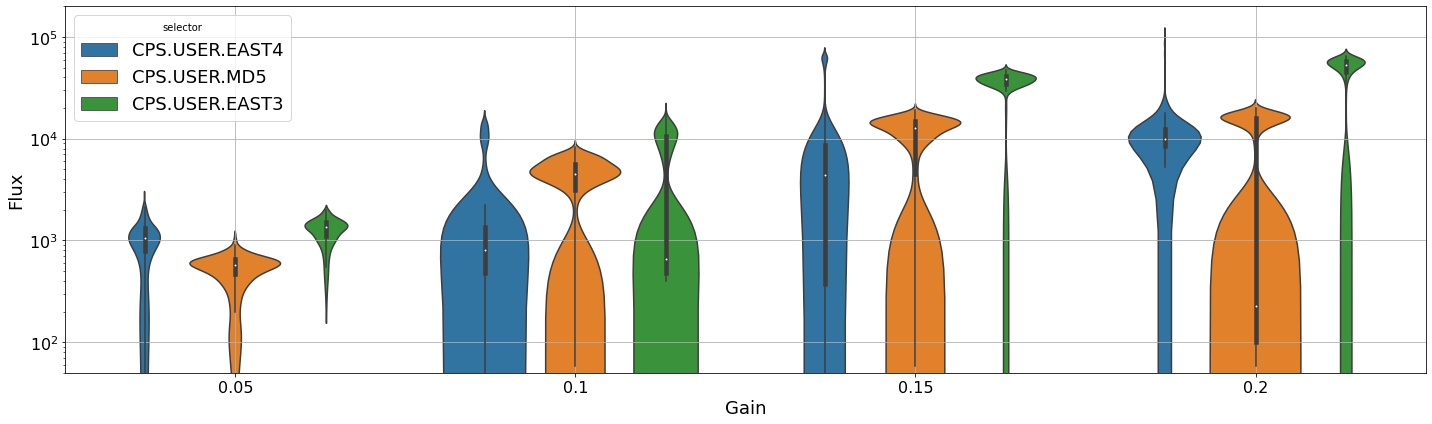

In [48]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 6))

# Define the gain values to filter
gain_values = [0.05, 0.1, 0.15, 0.2]

# Filter the DataFrame based on the gain values
filtered_df = df[df['gain'].isin(gain_values)]

# Create violin plot
sns.violinplot(x='gain', y='flux', hue='selector', data=filtered_df, ax=ax)

ax.set_xlabel('Gain')
ax.set_ylabel('Flux')
ax.grid(True)
ax.set_yscale("log")
ax.set_ylim(5e1,2e5)

plt.tight_layout()
plt.show()

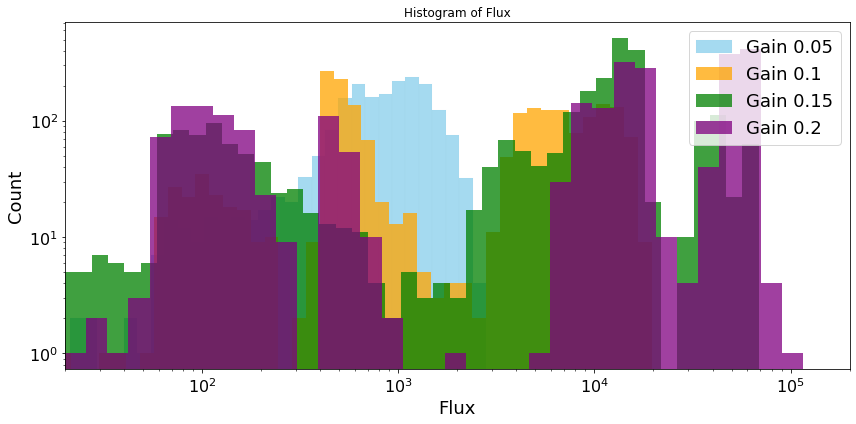

In [90]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)

# Define the gain values to filter
gain_values = [0.05, 0.1, 0.15, 0.2]

# Define a color palette for the gains
colors = ['skyblue', 'orange', 'green', 'purple']

for gain, color in zip(gain_values, colors):

    # Filter the DataFrame based on the gain values
    filtered_df = df[df['gain'] == gain]

    # Drop NaN values in the 'flux' column from the filtered DataFrame
    filtered_df = filtered_df.dropna(subset=['flux'])

    # Ensure there are no zero values before taking log
    filtered_df['flux'] = filtered_df['flux'].replace(0, np.nan)
    filtered_df = filtered_df.dropna(subset=['flux'])

    # Create logarithmically spaced bin edges
    bin_edges = np.logspace(np.log10(filtered_df['flux'].min()), np.log10(filtered_df['flux'].max()), num=50)

    # Create histogram with logarithmic bins and specific color
    sns.histplot(data=filtered_df, x='flux', bins=bin_edges, log_scale=(False, True), color=color, label=f'Gain {gain}')

ax.set_xlabel('Flux')
ax.set_ylabel('Count')
ax.set_title('Histogram of Flux')
ax.set_xscale('log')
ax.set_xlim(2e1, 2e5)
ax.legend()

plt.show()
